In [7]:
import os
import cv2
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import imantics
from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split
%matplotlib inline

In [10]:
base_dir = 'archive/png'
images_dir ='archive/png/train'
masks_dir = 'archive/png/train_labels'
test_images_dir = 'archive/png/test'
test_masks_dir = 'archive/png/test_labels'

image_size = 512
input_image_size = (512, 512)

In [11]:
def read_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (image_size, image_size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [12]:
def load_data(images_dir, masks_dir):
    images_listdir = os.listdir(images_dir)
    masks_listdir = os.listdir(masks_dir)
    
    IMAGES = []
    MASKS = []
    
    for img_file in images_listdir:
        try:
            image = read_image(os.path.join(images_dir, img_file))
            mask = read_image(os.path.join(masks_dir, img_file.replace('.png', '.png')))
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
            mask = mask.reshape(image_size, image_size, 1)
            
            IMAGES.append(image)
            MASKS.append(mask)
        except Exception as e:
            print(f"Error processing {img_file}: {e}")
    
    IMAGES = np.array(IMAGES, dtype=np.uint8)
    MASKS = np.array(MASKS, dtype=bool)
    return IMAGES, MASKS


In [13]:
images, masks = load_data(images_dir, masks_dir)
test_images, test_masks = load_data(test_images_dir, test_masks_dir)

print(images.shape, masks.shape)
print(test_images.shape, test_masks.shape)

(137, 512, 512, 3) (137, 512, 512, 1)
(10, 512, 512, 3) (10, 512, 512, 1)


In [14]:
images_train, images_val, masks_train, masks_val = train_test_split(images, masks, test_size=0.2, random_state=42)

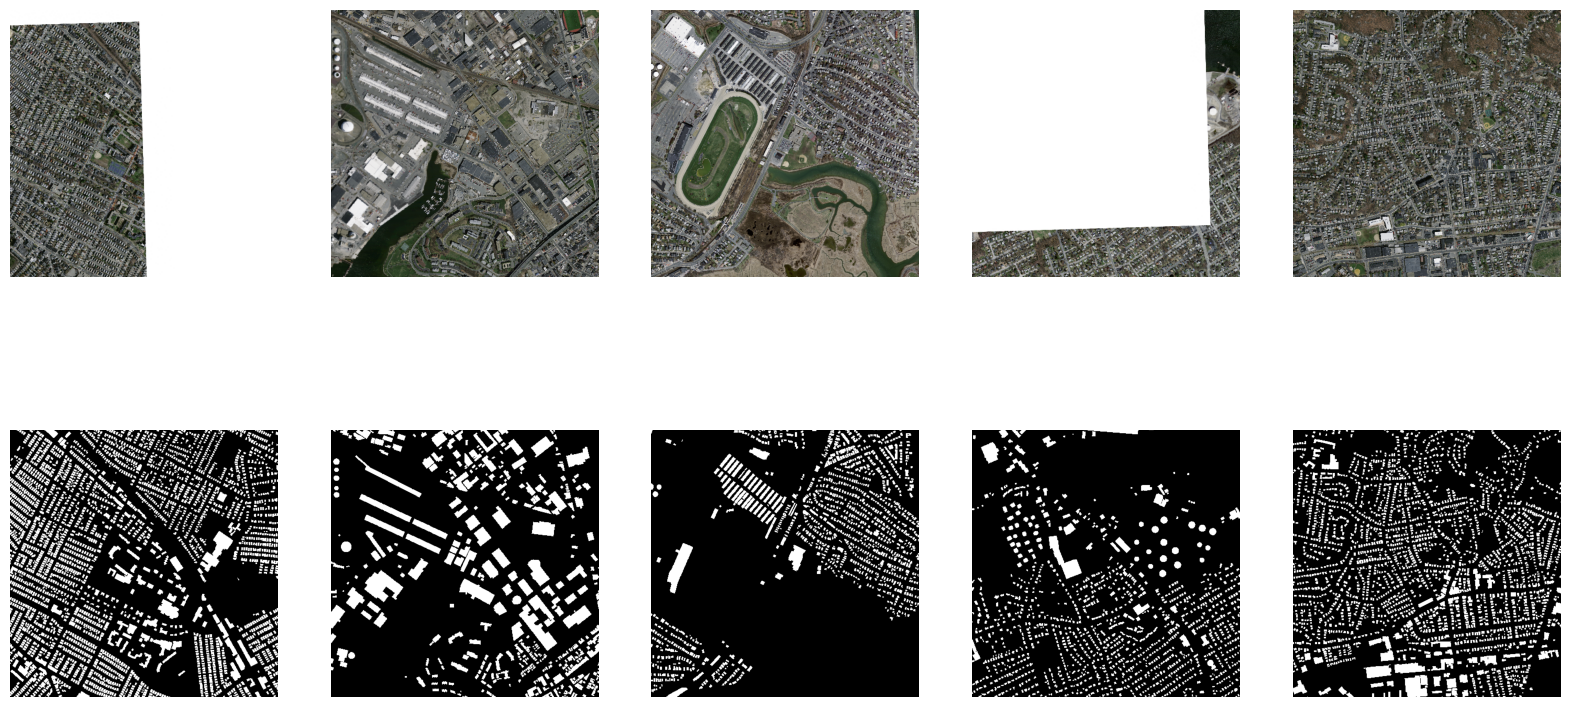

In [15]:
def plot_images(images, masks, num=5):
    random_indices = np.random.choice(images.shape[0], num, replace=False)
    plt.figure(figsize=(20, 10))
    for i, idx in enumerate(random_indices):
        plt.subplot(2, num, i + 1)
        plt.imshow(images[idx])
        plt.axis('off')
        plt.subplot(2, num, i + 1 + num)
        plt.imshow(masks[idx].squeeze(), cmap='gray')
        plt.axis('off')
    plt.show()

plot_images(images_train, masks_train, num=5)

In [9]:
data_gen_args = dict(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

image_datagen.fit(images_train, augment=True)
mask_datagen.fit(masks_train, augment=True)

def image_mask_generator(image_datagen, mask_datagen, images, masks, batch_size):
    image_generator = image_datagen.flow(images, batch_size=batch_size, seed=42)
    mask_generator = mask_datagen.flow(masks, batch_size=batch_size, seed=42)
    
    while True:
        image_batch, mask_batch = next(image_generator), next(mask_generator)
        mask_batch = mask_batch / 255.0
        yield image_batch, mask_batch

batch_size = 4 
train_generator = image_mask_generator(image_datagen, mask_datagen, images_train, masks_train, batch_size)

In [10]:
def conv_block(input, num_filters):
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(input)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(conv)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    return conv

def encoder_block(input, num_filters):
    skip = conv_block(input, num_filters)
    pool = tf.keras.layers.MaxPool2D((2, 2))(skip)
    return skip, pool

def decoder_block(input, skip, num_filters):
    up_conv = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    conv = tf.keras.layers.Concatenate()([up_conv, skip])
    conv = conv_block(conv, num_filters)
    return conv

def Unet(input_shape):
    inputs = tf.keras.layers.Input(input_shape)

    skip1, pool1 = encoder_block(inputs, 64)
    skip2, pool2 = encoder_block(pool1, 128)
    skip3, pool3 = encoder_block(pool2, 256)
    skip4, pool4 = encoder_block(pool3, 512)

    bridge = conv_block(pool4, 1024)

    decode1 = decoder_block(bridge, skip4, 512)
    decode2 = decoder_block(decode1, skip3, 256)
    decode3 = decoder_block(decode2, skip2, 128)
    decode4 = decoder_block(decode3, skip1, 64)
    
    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(decode4)
    model = tf.keras.models.Model(inputs, outputs, name="U-Net")
    return model

unet_model = Unet((512, 512, 3))
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
unet_model.summary()

2024-07-07 07:41:57.348150: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-07-07 07:41:57.348194: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-07-07 07:41:57.348203: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-07-07 07:41:57.348238: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-07 07:41:57.348259: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512, 512,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │      1,024 │ conv2d_4[0][0]  

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [11]:
epochs = 50
steps_per_epoch = len(images_train) // batch_size

unet_model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch
)

unet_model.save('unet_model.keras')

Epoch 1/50


2024-07-07 07:42:18.736740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


27/27 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step - accuracy: 0.6772 - loss: 0.4030
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.7877 - loss: 0.0886
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 103s 4s/step - accuracy: 0.7953 - loss: 0.0503
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 110s 4s/step - accuracy: 0.7748 - loss: 0.0352
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 123s 5s/step - accuracy: 0.7839 - loss: 0.0279
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 124s 5s/step - accuracy: 0.7809 - loss: 0.0219
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 136s 5s/step - accuracy: 0.8017 - loss: 0.0178
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 147s 5s/step - accuracy: 0.7877 - loss: 0.0155
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 154s 6s/step - accuracy: 0.7844 - loss: 0.0136
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 142s 5s/step - accuracy: 0.7927 - loss: 0.0118
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 154s 6s/step - accuracy: 0.7753 - loss: 0.0108
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 156s 6s/step - accuracy: 0.7930 - los

In [22]:
unet_model = tf.keras.models.load_model('unet_model.keras')

val_loss, val_accuracy = unet_model.evaluate(images_val, masks_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step


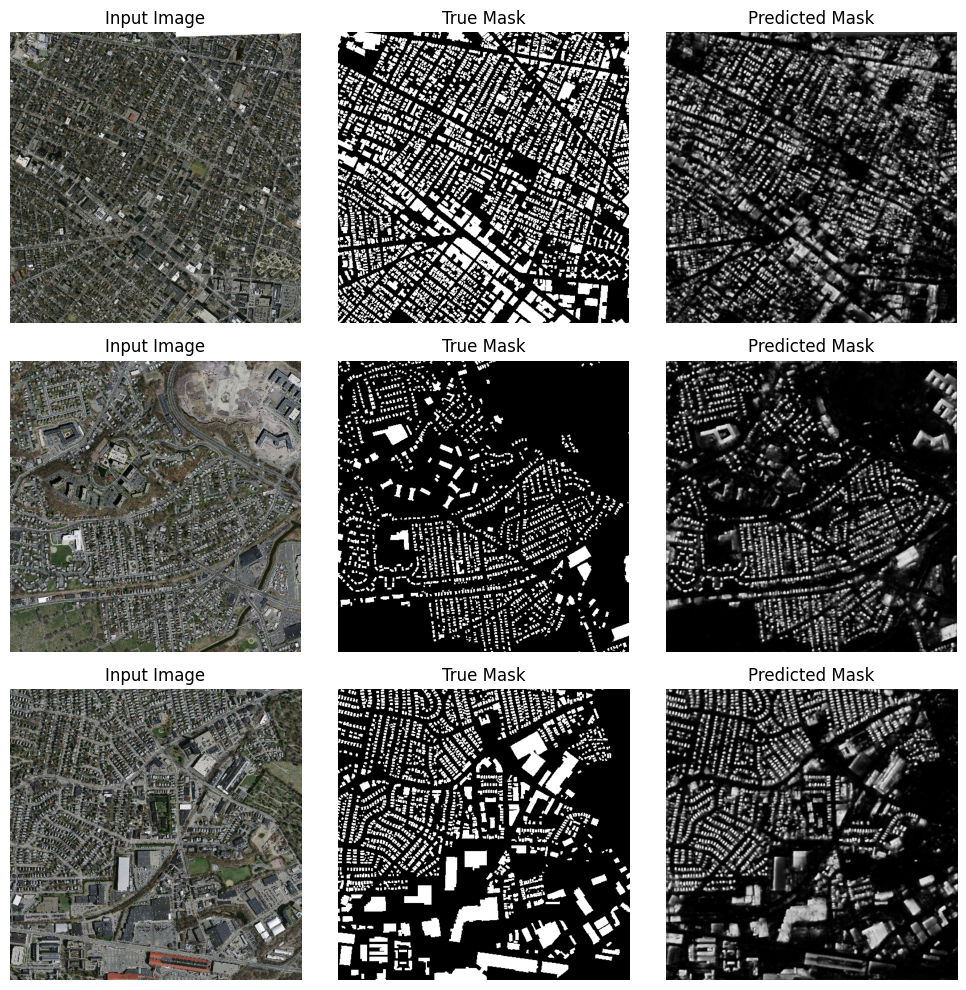

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


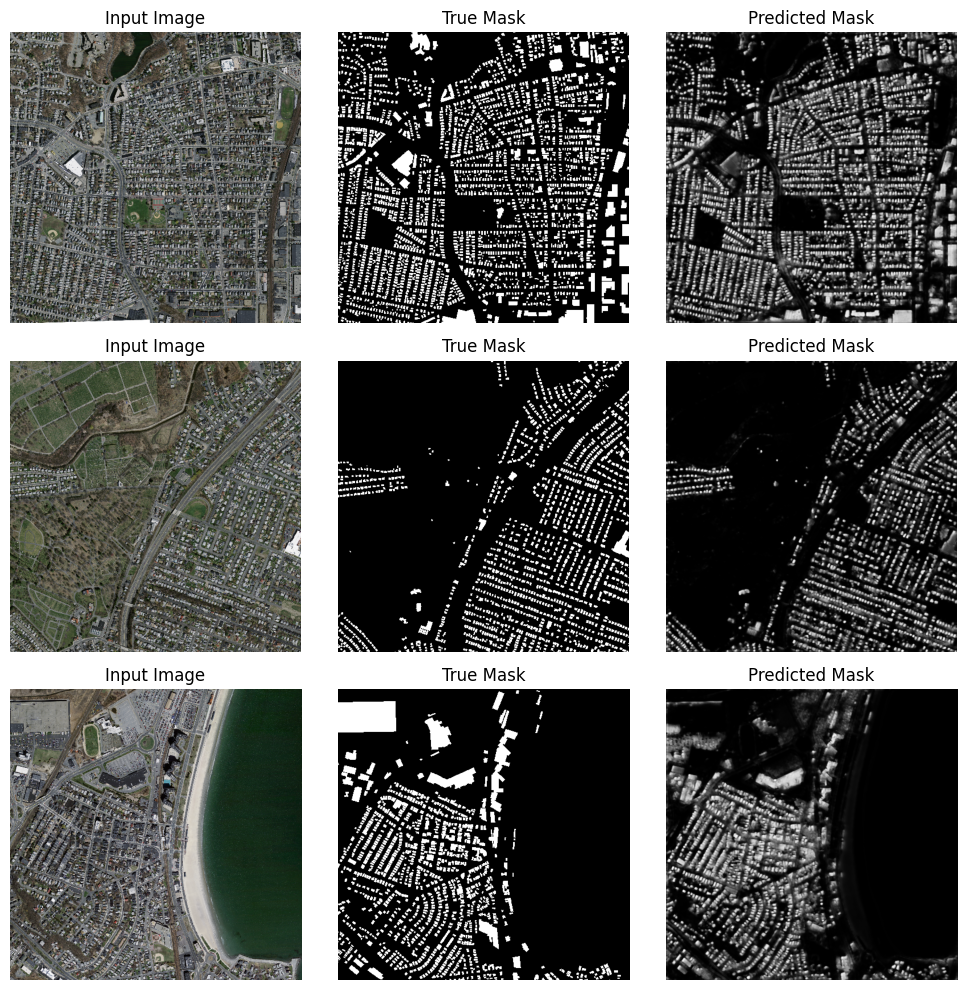

In [ ]:
def plot_sample_images(images, masks, predictions=None):
    plt.figure(figsize=(10, 10))
    for i in range(3):
        plt.subplot(3, 3, i*3 + 1)
        plt.imshow(images[i])
        plt.title('Input Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i*3 + 2)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title('True Mask')
        plt.axis('off')
        
        if predictions is not None:
            plt.subplot(3, 3, i*3 + 3)
            plt.imshow(predictions[i].squeeze(), cmap='gray')
            plt.title('Predicted Mask')
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

train_predictions = unet_model.predict(images_train[:3])
plot_sample_images(images_train[:3], masks_train[:3], train_predictions)

test_predictions = unet_model.predict(test_images[:3])
plot_sample_images(test_images[:3], test_masks[:3], test_predictions)